In [1]:

import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
    !pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/week05_explore/bayes.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/week05_explore/action_rewards.npy
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/week05_explore/all_states.npy

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     \ 26.8MB 10.7MB/s
  Created wheel for Theano: filename=Theano-1.0.5-cp36-none-any.whl size=2667181 sha256=b31b3d621c1f3399ec422578a68ea3001b31e75191e01e0e5fbceb04800e3a9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-go54pmww/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5
     / 819kB 4.1MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122797 sha256=db0ecf2b6c9394788fc21a86d4af84ddd49c435615c9c37e69bd66579a67d8b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pi9y

In [2]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Contents
* [1. Bernoulli Bandit](#Part-1.-Bernoulli-Bandit)
    * [Bonus 1.1. Gittins index (5 points)](#Bonus-1.1.-Gittins-index-%285-points%29.)
    * [HW 1.1. Nonstationary Bernoulli bandit](#HW-1.1.-Nonstationary-Bernoulli-bandit)
* [2. Contextual bandit](#Part-2.-Contextual-bandit)
    * [2.1 Bulding a BNN agent](#2.1-Bulding-a-BNN-agent)
    * [2.2 Training the agent](#2.2-Training-the-agent)
    * [HW 2.1 Better exploration](#HW-2.1-Better-exploration)
* [3. Exploration in MDP](#Part-3.-Exploration-in-MDP)
    * [Bonus 3.1 Posterior sampling RL (3 points)](#Bonus-3.1-Posterior-sampling-RL-%283-points%29)
    * [Bonus 3.2 Bootstrapped DQN (10 points)](#Bonus-3.2-Bootstrapped-DQN-%2810-points%29)


## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [3]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [4]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow \arg\max_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

\emph{Notation}: $\alpha$ is successes and $\beta$ is failures!

Implement the algorithm above in the cell below:

In [5]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        r_eps = np.random.random()
        prob = self._successes / ( self._successes + self._failures )
        res = np.argmax(prob) if r_eps > self._epsilon else np.random.choice(len(self._successes))
        return res

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow \arg\max_{k} w_{k}$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [6]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        sum_s_f = self._successes + self._failures
        prob = self._successes / sum_s_f
        ucb  = np.sqrt( 2 * np.log2(self._total_pulls) / sum_s_f )
        w = prob + ucb               
        return np.argmax(w)

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim Beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow \arg\max_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**
 

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [7]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        eps = 1e-12
        sample = np.random.beta(self._successes + eps, self._failures + eps)
        return np.argmax(sample)

In [8]:
print(np.random.beta([1,2,3],[3,2,1]))

[0.086 0.271 0.511]


In [9]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


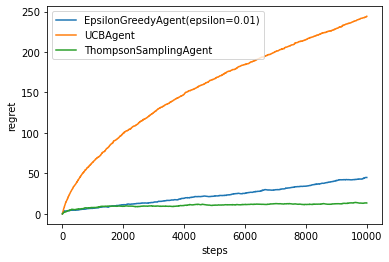

In [10]:
# Uncomment agents
agents = [
         EpsilonGreedyAgent(),
         UCBAgent(),
         ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

# Bonus 1.1. Gittins index (5 points).

Bernoulli bandit problem has an optimal solution - Gittins index algorithm. Implement finite horizon version of the algorithm and demonstrate it's performance with experiments. some articles:
- Wikipedia article - https://en.wikipedia.org/wiki/Gittins_index
- Different algorithms for index computation - http://www.ece.mcgill.ca/~amahaj1/projects/bandits/book/2013-bandit-computations.pdf (see "Bernoulli" section)
    

# HW 1.1. Nonstationary Bernoulli bandit

What if success probabilities change over time? Here is an example of such bandit:

In [11]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

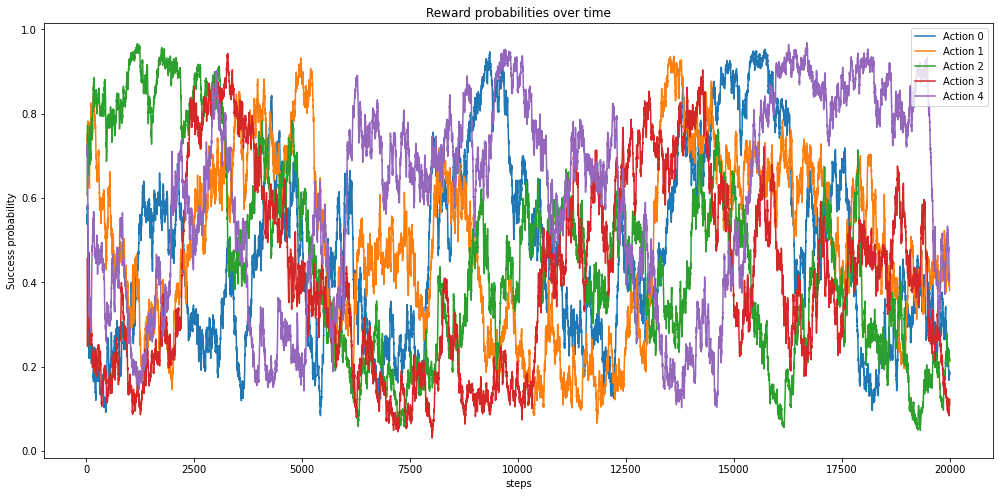

In [12]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

Your task is to invent an agent that will have better regret than stationary agents from above.

In [13]:
# YOUR AGENT HERE SECTION
class myAgent(AbstractAgent):
    def get_action(self):
        eps = 1e-12

        sample = np.random.beta(self._successes + eps, self._failures + eps)
        return np.argmax(sample)

    def update(self, action, reward):
        self._total_pulls += 1

        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

        g = 0.01
        self._successes = self._successes * (1 - g) + g
        self._failures  = self._failures * (1 - g) + g


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


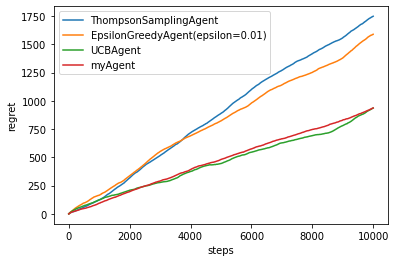

In [14]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    myAgent()
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=10000, n_trials=10)
plot_regret(drifting_agents, regret)

## Part 2. Contextual bandit

Now we will solve much more complex problem - reward will depend on bandit's state.

**Real-word analogy:**

> Contextual advertising. We have a lot of banners and a lot of different users. Users can have different features: age, gender, search requests. We want to show banner with highest click probability.

If we want use strategies from above, we need some how store reward distributions conditioned both on actions and bandit's state. 
One way to do this - use bayesian neural networks. Instead of giving pointwise estimates of target, they maintain probability distributions

<img src="https://github.com/yandexdataschool/Practical_RL/blob/spring20/week05_explore/bnn.png?raw=1">
Picture from https://arxiv.org/pdf/1505.05424.pdf


More material:
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)
  
Let's load our dataset:

In [15]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

print("State size: %i, actions: %i" % (state_size, n_actions))

State size: 60, actions: 10


In [16]:
for s in all_states[:1]:
    print(s)
    print(s.shape)
    

print()
for ar in action_rewards[:3]:
    print(ar)
    print(ar.shape)

print()
print(np.max(action_rewards))

[0.25  0.25  0.    0.875 0.312 0.812 0.    0.    0.5   0.    0.    0.75
 0.    0.938 0.    0.562 0.    0.    0.938 0.    0.688 0.    0.5   0.
 0.75  0.312 0.    0.    0.    0.    0.312 0.    0.625 0.    0.    0.062
 0.    0.188 0.    0.    0.5   0.    0.625 0.375 0.75  0.688 0.    0.125
 0.    0.312 0.812 0.938 0.812 0.    0.    0.062 0.    0.625 0.5   0.   ]
(60,)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(10,)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(10,)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(10,)

1.0


In [17]:
import theano
import theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *
import bayes

as_bayesian = bayes.bbpwrap(bayes.NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)

## 2.1 Bulding a BNN agent

Let's implement epsilon-greedy BNN agent

In [18]:
class BNNAgent:
    """a bandit with bayesian neural net"""

    def __init__(self, state_size, n_actions):
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")

        self.total_samples_seen = theano.shared(
            np.int32(0), "number of training samples seen so far")
        batch_size = target_actions.shape[0]  # por que?

        # Network
        inp = InputLayer((None, state_size), name='input')
        # YOUR NETWORK HERE
        hl_1 = BayesDenseLayer(inp, num_units=32,
                              nonlinearity=lasagne.nonlinearities.rectify)
        out = BayesDenseLayer(hl_1, num_units=n_actions,
                              nonlinearity=lasagne.nonlinearities.softmax)

        # Prediction
        # lasagne.layers.get_output
        prediction_all_actions = get_output(out, inputs=input_states)
        self.predict_sample_rewards = theano.function(
            [input_states], prediction_all_actions)

        # Training

        # select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(
            batch_size), target_actions]

        # loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2)

        kl = bayes.get_var_cost(out) / (self.total_samples_seen + batch_size)

        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out, trainable=True)
        self.out = out

        # gradient descent
        updates = lasagne.updates.adam(loss, self.weights)

        # update counts
        updates[self.total_samples_seen] = self.total_samples_seen + \
            batch_size.astype('int32')

        self.train_step = theano.function([input_states, target_actions, target_rewards],
                                          [negative_llh, kl],
                                          updates=updates,
                                          allow_input_downcast=True)

    def sample_prediction(self, states, n_samples=1):
        """Samples n_samples predictions for rewards,

        :returns: tensor [n_samples, state_i, action_i]
        """
        assert states.ndim == 2, "states must be 2-dimensional"

        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])


    def get_action(self, states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """
        
        epsilon = 0.25
        batch_size = states.shape[0]

        reward_samples = self.sample_prediction(states, n_samples=100)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]

        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        # ^-- we take mean over samples to compute expectation, then pick best action with argmax

        random_actions = np.random.choice(n_actions, size=batch_size)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        chosen_actions = np.where(should_explore, random_actions, best_actions)

        return chosen_actions

    def train(self, states, actions, rewards, n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss, kl = self.train_step(states, actions, rewards)
            loss_sum += loss
            kl_sum += kl

        return loss_sum / n_iters, kl_sum / n_iters

    @property
    def name(self):
        return self.__class__.__name__

## 2.2 Training the agent

In [19]:
N_ITERS = 100

In [20]:
def get_new_samples(states, action_rewards, batch_size=10):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]

In [21]:
from IPython.display import clear_output

from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

def train_contextual_agent(agent, batch_size=10, n_iters=100):
    rewards_history = []

    for i in range(n_iters):
        b_states, b_action_rewards = get_new_samples(
            all_states, action_rewards, batch_size)
        b_actions = agent.get_action(b_states)
        b_rewards = b_action_rewards[
            np.arange(batch_size), b_actions
        ]

        mse, kl = agent.train(b_states, b_actions, b_rewards, n_iters=100)

        rewards_history.append(b_rewards.mean())

        if i % 10 == 0:
            clear_output(True)
            print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f" %
                  (i, np.mean(rewards_history[-10:]), mse, kl))
            plt.plot(rewards_history)
            plt.plot(moving_average(np.array(rewards_history), alpha=0.1))
            plt.title("Reward per epesode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

            samples = agent.sample_prediction(
                b_states[:1], n_samples=100).T[:, 0, :]
            for i in range(len(samples)):
                plt.hist(samples[i], alpha=0.25, label=str(i))
                plt.legend(loc='best')
            print('Q(s,a) std:', ';'.join(
                list(map('{:.3f}'.format, np.std(samples, axis=1)))))
            print('correct', b_action_rewards[0].argmax())
            plt.title("p(Q(s, a))")
            plt.show()

    return moving_average(np.array(rewards_history), alpha=0.1)

iteration #90	mean reward=0.550	mse=0.155	kl=0.072


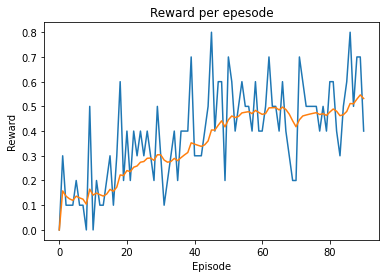

Q(s,a) std: 0.014;0.000;0.000;0.000;0.010;0.001;0.001;0.000;0.001;0.004
correct 0


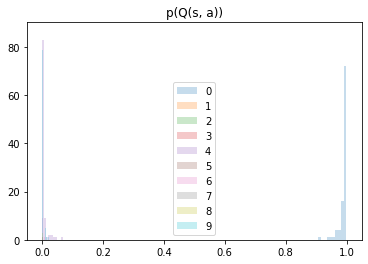

In [22]:
bnn_agent = BNNAgent(state_size=state_size, n_actions=n_actions)
greedy_agent_rewards = train_contextual_agent(
    bnn_agent, batch_size=10, n_iters=N_ITERS)

## HW 2.1 Better exploration

Use strategies from first part to gain more reward in contextual setting

In [23]:
class ThompsonBNNAgent(BNNAgent):
    def get_action(self, states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward (yes, that simple)
        This is exactly thompson sampling.
        """

        reward_samples = self.sample_prediction(states, n_samples=1)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        best_actions = reward_samples[0].argmax(axis=-1)
        
        return best_actions

iteration #90	mean reward=0.730	mse=0.074	kl=0.081


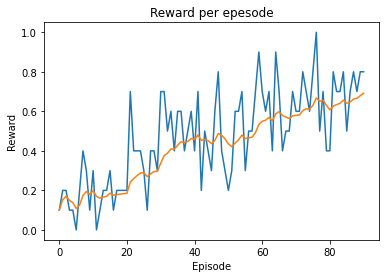

Q(s,a) std: 0.000;0.000;0.001;0.020;0.000;0.000;0.000;0.000;0.002;0.019
correct 3


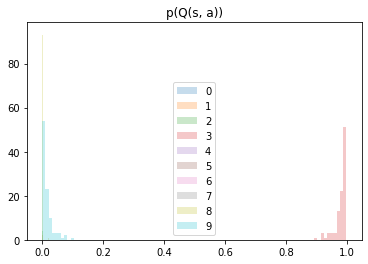

In [24]:
t_agent = ThompsonBNNAgent(state_size=state_size, n_actions=n_actions)
thompson_agent_rewards = train_contextual_agent(t_agent, batch_size=10, n_iters=N_ITERS)

In [25]:
class BayesUCBBNNAgent(BNNAgent):
    
    def __init__(self, state_size, n_actions, n_iters):
        super().__init__(state_size, n_actions)
        self.n_iters = n_iters
        self.c_iter = 1

        
    def get_action(self, states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.

        This implements bayesian UCB strategy
        """
        reward_samples = self.sample_prediction(states, n_samples=100)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        
        q = 1 - 1/(self.c_iter * np.sqrt(np.log2(self.n_iters)))
        reward_quantiles = np.quantile(reward_samples, q=q, axis=0)
        best_actions = reward_quantiles.argmax(axis=-1)

        self.c_iter += self.c_iter
        
        return best_actions

iteration #90	mean reward=0.820	mse=0.084	kl=0.086


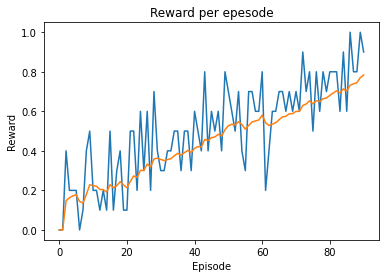

Q(s,a) std: 0.024;0.001;0.000;0.001;0.005;0.009;0.032;0.000;0.003;0.000
correct 6


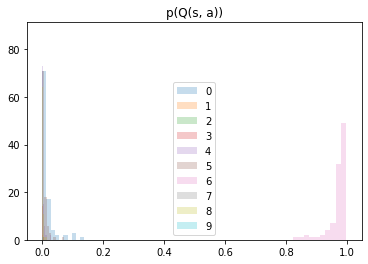

In [26]:
b_ucb_agent = BayesUCBBNNAgent(state_size=state_size, n_actions=n_actions, n_iters=N_ITERS)
ucb_agent_rewards = train_contextual_agent(b_ucb_agent, batch_size=10, n_iters=N_ITERS)

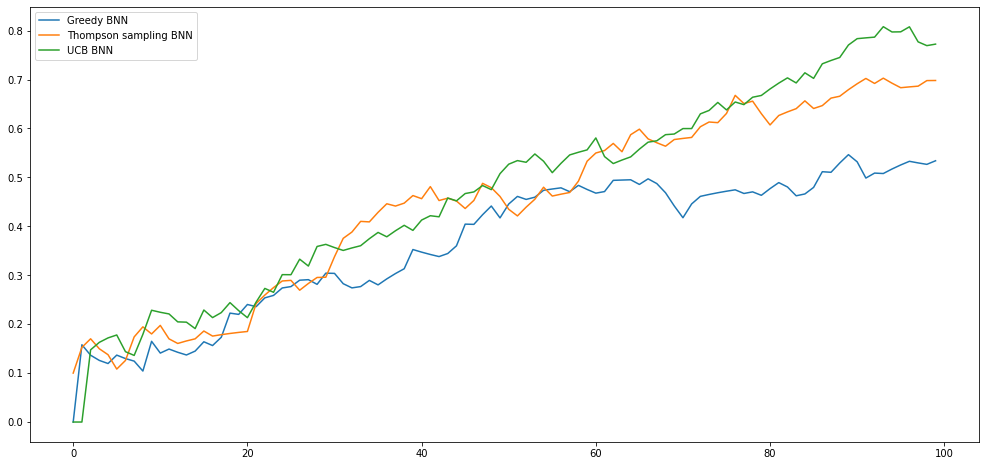

In [27]:
plt.figure(figsize=(17, 8))

plt.plot(greedy_agent_rewards)
plt.plot(thompson_agent_rewards)
plt.plot(ucb_agent_rewards)

plt.legend([
    "Greedy BNN",
    "Thompson sampling BNN",
    "UCB BNN"
])

plt.show()

## Part 3. Exploration in MDP

The following problem, called "river swim", illustrates importance of exploration in context of mdp's.

<img src="https://github.com/yandexdataschool/Practical_RL/blob/spring20/week05_explore/river_swim.png?raw=1">

Picture from https://arxiv.org/abs/1306.0940

Rewards and transition probabilities are unknown to an agent. Optimal policy is to swim against current, while easiest way to gain reward is to go left.

In [28]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0

    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()

    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False

    @property
    def n_actions(self):
        return 2

    @property
    def n_states(self):
        return 2 + self._interm_states

    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]

        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError(
                "Unknown action {}. Max action is {}".format(action, self.n_actions))

    def step(self, action):
        """
        :param action:
        :type action: int
        :return: observation, reward, is_done
        :rtype: (int, float, bool)
        """
        reward = 0.0

        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = np.random.choice(
            range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD

        self._steps += 1
        return self._current_state, reward, False

Let's implement q-learning agent with epsilon-greedy exploration strategy and see how it performs.

In [29]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        """ Used for policy visualization
        """
        return self._q_matrix

    def start_episode(self):
        """ Used in PSRL agent
        """
        pass

    def update(self, state, action, reward, next_state):
        # Finish implementation of q-learnig agent
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        g = self._gamma
        lr = self._lr
        Q_mtx = self._q_matrix

        Q_sa = (1 - lr) * Q_mtx[state][action] \
                + lr * ( reward + g * np.max(Q_mtx[next_state]) )

        self._q_matrix[state][action]= Q_sa

In [30]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []

    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)

            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    return episode_rewards

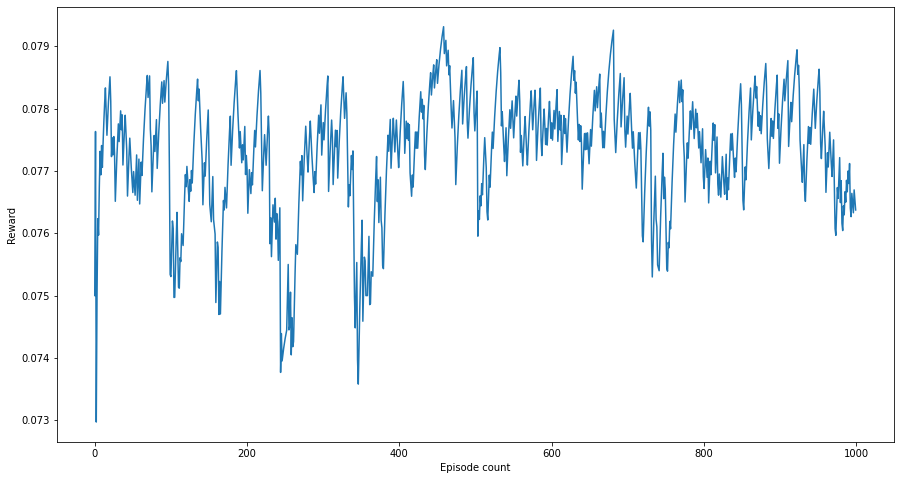

In [117]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(moving_average(np.array(rews), alpha=.1))
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Let's visualize our policy:

In [32]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(['', 'left', 'right'])
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.title("Values of state-action pairs")
    plt.show()

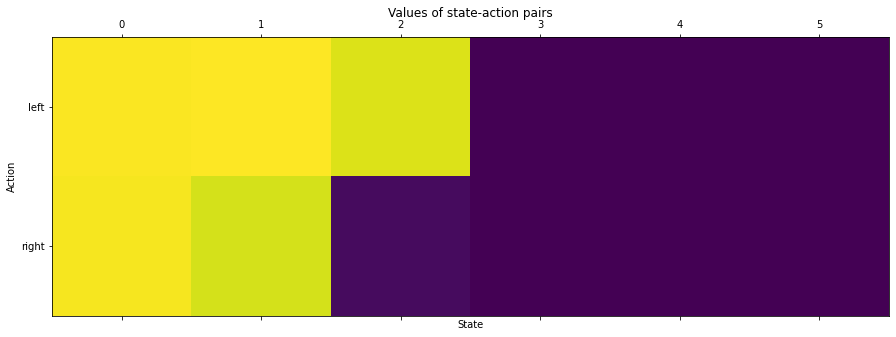

In [33]:
plot_policy(agent)

As your see, agent uses suboptimal policy of going left and does not explore the right state.

## Bonus 3.1 Posterior sampling RL (3 points)

Now we will implement Thompson Sampling for MDP!

General algorithm:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**

In our case we will model $M_k$ with two matricies: transition and reward. Transition matrix is sampled from dirichlet distribution. Reward matrix is sampled from normal-gamma distribution.

Distributions are updated with bayes rule - see continious distribution section at https://en.wikipedia.org/wiki/Conjugate_prior

Article on PSRL - https://arxiv.org/abs/1306.0940

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

In [110]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu, 1.0 / np.sqrt(lmbd * tau))
    return mu, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon
        
        # params for transition sampling - Dirichlet distribution
        self._transition_counts = np.zeros(
            (n_states, n_states, n_actions)) + 1.0

        # params for reward sampling - Normal-gamma distribution
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros(
            (n_states, n_actions)) + 1.0  # lambda

        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0

        # mean reward from observations
        self._reward_mean_obs = np.zeros((n_states, n_actions)) + 1.0
        self._reward_var_obs = np.zeros((n_states, n_actions)) + 1.0
        self._lambda_0 = np.zeros((n_states, n_actions)) + 1.0


    def _value_iteration(self, transitions, rewards):
        # YOU CODE HERE
        
        # parameters
        g = 0.9                # discount for MDP
        num_iter = 10**4       # maximum iterations, excluding initialization
        min_diff = 0.001       # stop VI if new values are this close to old values (or closer)

        # initialize V(s)
        all_states = list(range(self._n_states))
        V = np.zeros((self._n_states,1)) #state_values
        
        for i in range(num_iter):
            V_next = np.zeros((self._n_states,1))
            for s in all_states:
                pos_actions = [0,1]
                l_Qsa = []
                for a in pos_actions:
                    Q_sa = rewards[s,a] + g * np.dot(transitions[s,:,a], V)
                    l_Qsa.append(Q_sa)
                V_next[s] = np.max(l_Qsa)
                
            # Compute difference
            diff = np.max( np.abs(V_next - V) )
            V = V_next
            if diff < min_diff:
                break
        return V


    def start_episode(self):
        
        # (n_states, n_actions)
        mu_0 = self._mu_matrix
        lmbd_0 = self._lambda_0
        alpha_0 = self._alpha_matrix
        beta_0 = self._beta_matrix
        sa_counts = self._state_action_counts
        mean_r = self._reward_mean_obs
        var_r = self._reward_var_obs

        # WIKI - Conjugate_prior
        # https://en.wikipedia.org/wiki/Conjugate_prior

        # mu = (v * mu_0 + n * hx ) / (v + n)
        # lamb = v + n
        # alpha = alpha + n/2
        # beta = beta + 0.5 * sum_{i=1}^{n}(x_i - hx)^2 + 0.5 * (hx - mu_0)^2 (n * v) / (v + n)

        mu_p = (lmbd_0 * mu_0 + sa_counts * mean_r ) / (lmbd_0 + sa_counts)
        lmbd_p = lmbd_0 +  sa_counts
        alpha_p = alpha_0 + sa_counts / 2
        beta_p = beta_0 + 0.5 * sa_counts * var_r + 0.5 * np.square(mean_r - mu_0) * (sa_counts * lmbd_0) / (lmbd_0 + sa_counts)
      

        # (n_states, n_actions)
        self._alpha_matrix
        self._beta_matrix



        # sample new mdp (update the transition matrix)
        self._sampled_transitions = np.apply_along_axis(
            np.random.dirichlet, 1, self._transition_counts)

        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            mu_p, #self._mu_matrix,
            lmbd_p, #self._state_action_counts,
            alpha_p, #self._alpha_matrix,
            beta_p, #self._beta_matrix
        )
        self._sampled_rewards = sampled_reward_mus

        self._current_value_function = self._value_iteration(
            self._sampled_transitions,
            self._sampled_rewards)


    # Our Policy
    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] +
                         np.dot(np.transpose(self._current_value_function), self._sampled_transitions[state]))


    def update(self, state, action, reward, next_state):
        #<YOUR CODE>
        # update rules - https://en.wikipedia.org/wiki/Conjugate_prior

        # (n_states, n_states, n_actions)
        self._transition_counts[state, next_state, action] += 1

        # (n_states, n_actions)
        self._state_action_counts[state, action] += 1

        n_obs_sa = self._state_action_counts[state, action]
        prev_mean_reward = self._reward_mean_obs[state, action]
        prev_var_reward = self._reward_var_obs[state, action]

        self._reward_mean_obs[state, action] = ((n_obs_sa - 1) * prev_mean_reward + reward ) / n_obs_sa
        self._reward_var_obs[state, action] = ((n_obs_sa - 1) * prev_var_reward + np.square(reward - prev_mean_reward)) / n_obs_sa


    def get_q_matrix(self):
        return self._sampled_rewards + np.dot(self._sampled_transitions, self._current_value_function)
        

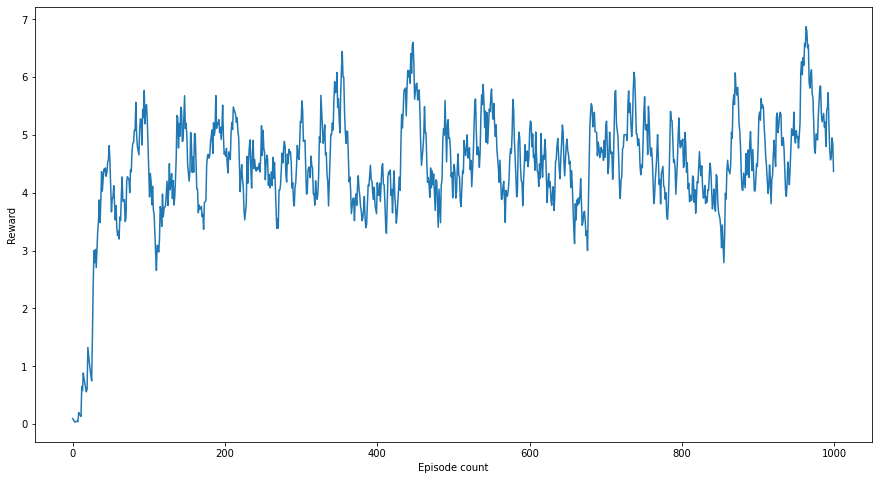

In [118]:
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

n_episodes = 1000
horizon = 20

#debug
#n_episodes = 1
#horizon = 1

env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, n_episodes)

plt.figure(figsize=(15, 8))
plt.plot(moving_average(np.array(rews), alpha=0.1))

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

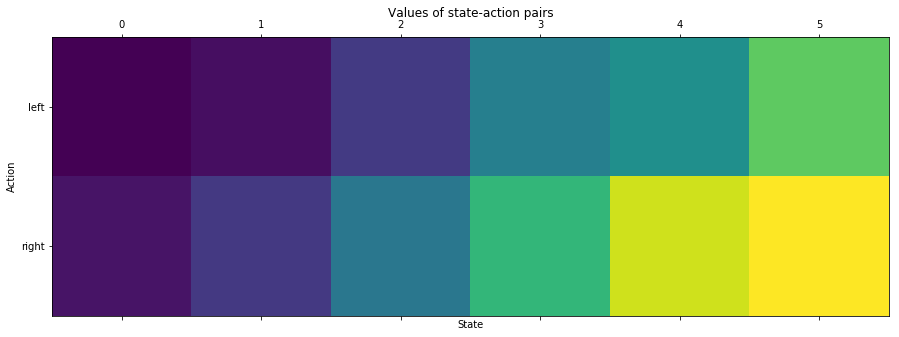

In [ ]:
plot_policy(agent)

## Bonus 3.2 Bootstrapped DQN (10 points)

Implement Bootstrapped DQN algorithm and compare it's performance with ordinary DQN on BeamRider Atari game. Links:
- https://arxiv.org/abs/1602.04621